# Mantis Keypoint Detection with Transfer Learning

**Description:** Training a keypoint detector with data augmentation and transfer learning. Based on https://keras.io/examples/vision/keypoint_detection/



In [2]:
# Ensure that the following imports are included to avoid any missing module errors
%pip install -q imgaug
%pip install -q keras
%pip install -q tensorflow
%pip install -q scikit-learn
%pip install -q pandas
%pip install -q numpy==1.26.0

from keras import layers

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define hyperparameters:
IMG_SIZE: length and width of the Mantis Images

BATCH_SIZE

EPOCH

NUM_KEYPOINTS: Number of Keypoints to detect. In this work we need to detect 5 Keypoints

In [3]:
IMG_SIZE = 640
BATCH_SIZE = 10
EPOCHS = 50
NUM_KEYPOINTS = 5 * 2  # 5 pairs each having x and y coordinates

## Load data

Loading the data (images and annotations) into an dict.

In [15]:
IMG_DIR = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisAIData\train"
JSON = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisAIData\MantisTrain.json"
KEYPOINT_DEF = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisKeypointDef.csv"

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Prepare the mapping for images and annotations
images = {image['id']: image for image in json_data['images']}
annotations = {annotation['image_id']: annotation for annotation in json_data['annotations']}

# Process keypoints to ensure they are 2D
raw_keypoints = annotations.get('keypoints', [])
if raw_keypoints:
  # Reshape the keypoints into a 2D array with shape (num_keypoints, 3)
  reshaped_keypoints = [raw_keypoints[i:i + 3] for i in range(0, len(raw_keypoints), 3)]
else:
  reshaped_keypoints = []

# Generate the desired output structure
json_dict = {}
for image_id, image_data in images.items():
    annotation = annotations.get(image_id, {})

    #convert joints to 2D Array
    keypoints = annotation.get('keypoints', [])
    joints_2d = np.array(keypoints).reshape(-1, 3) if keypoints else []

    # Map the image and annotation data to the desired structure
    json_dict[image_data['file_name']] = {
        'img_bbox': annotation.get('bbox', []),
        'img_height': image_data['height'],
        'img_path': image_data['file_name'],
        'img_width': image_data['width'],
        'joints': joints_2d.tolist()
    }

# Example: Accessing a single entry from json_dict
for path, entry in json_dict.items():
    print(f"'{path}': {entry}")
    joints = entry.get('joints', [])
    joints_array = np.array(joints)

    # Print the information
    print(f"Image Path: {path}")
    print(f"Joints Array:\n{joints_array}")
    print(f"Shape: {joints_array.shape}")
    break  # Just show one example


'Hypsicorypha-gracilis_F1_S1_23-14-07_C001H001S0001002170_jpg.rf.042980f65f3e5d8d90e0d154fd392b36.jpg': {'img_bbox': [46, 263, 585.231, 381.692], 'img_height': 1024, 'img_path': 'Hypsicorypha-gracilis_F1_S1_23-14-07_C001H001S0001002170_jpg.rf.042980f65f3e5d8d90e0d154fd392b36.jpg', 'img_width': 1024, 'joints': [[588.077, 340.0, 2.0], [307.692, 469.231, 2.0], [228.846, 301.538, 2.0], [211.154, 524.615, 2.0], [149.231, 483.462, 2.0]]}
Image Path: Hypsicorypha-gracilis_F1_S1_23-14-07_C001H001S0001002170_jpg.rf.042980f65f3e5d8d90e0d154fd392b36.jpg
Joints Array:
[[588.077 340.      2.   ]
 [307.692 469.231   2.   ]
 [228.846 301.538   2.   ]
 [211.154 524.615   2.   ]
 [149.231 483.462   2.   ]]
Shape: (5, 3)


In [16]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex color"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()


# Utility for reading an image and for getting its annotations.
def get_mantis(name):
    """
    Loads the imae and its annotations for a given file name from the JSON data.

    Args:
             name(str) -- The name of the image to load, as listed in json_dict

    Returns:
                dict -- A dictionary with the following information:
                    - img_bbox: The bounding box coordinates for the image
                    - img_height: The height of the image in pixels
                    - img_path: The path to the image file
                    - img_width: The width of the image in pixels
                    - joints: The joint coordinates/Keypoints for the image ([x,y,visibility])
                    - img_data: The image data as a NumPy array
    """
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data


## Visualize data

Now, we write a utility function to visualize the images and their keypoints.

In [17]:

# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    """
    Visualizes images alongside their annotated keypoints.

    Args:
            images (list of np.ndarray): A list of images, where each images is represented as a NumPy array
            keypoints (list): A list of keypoint annotations corresponding to each image.
                            Each keypoint is represented as a list of [x, y, visibility] or imgaug KeypointsOnImage

    Returns:
            Each image is shown twice in a grid:
                - The original image
                - The image with the keypoints overlaid
            Keypoints are plotted with color-coding based on their index

    Keypoint Format:
            If keypoints are plain arrays:
                Each keypoint is represented as [x, y, visibility], where:
                    - x and y: coordinates of the keypoint
                    - visibility: 2 indicates visible; other values are ignored
            If keypoints are imgaug KeypointsOnImage:
                    - Each keypoint is extracted and plotted
    """
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 15))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            x_coords = []
            y_coords = []
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
                x_coords.append(kp.x)
                y_coords.append(kp.y)
            # Draw lines connecting the keypoints in sequence 0->1->2->3->4
            for i in range(len(x_coords) - 1):
                ax_all.plot([x_coords[i], x_coords[i + 1]], [y_coords[i], y_coords[i + 1]], c="g", linewidth=1)
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            x_coords, y_coords = [], []
            for idx, (x, y) in enumerate(current_keypoint):
              ax_all.scatter([x], [y], c=colours[idx], marker=".", s=10, linewidths=2)
              x_coords.append(x)
              y_coords.append(y)
            for i in range(len(x_coords) - 1):
                ax_all.plot([x_coords[i], x_coords[i + 1]], [y_coords[i], y_coords[i + 1]], c="g", linewidth=1)
    plt.tight_layout(pad=2.0)
    plt.show()

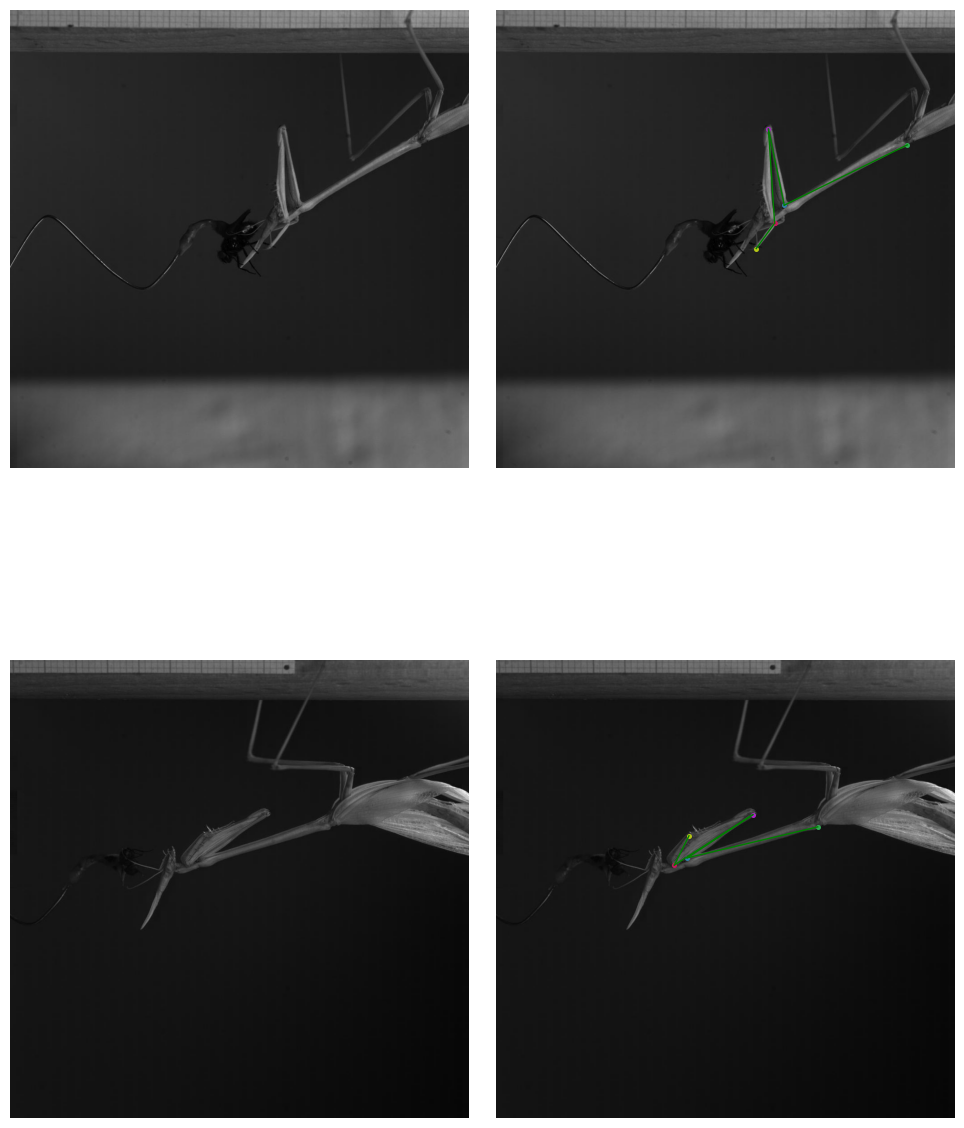

In [18]:
# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 2
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_mantis(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In the next section, we will write a data generator inheriting the
[`keras.utils.Sequence`](https://keras.io/api/utils/python_utils/#sequence-class) class
that applies data augmentation on batches of data using `imgaug`.

## Prepare data generator

In [21]:
import keras
class KeyPointsDataset(keras.utils.PyDataset):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        """
        Initializes the KeyPointsDataset for managing and preprocessing data.

        Args:
            image_keys (list): A list of image identifiers used to access the dataset
            aug (callable): A function or object to apply data augmentation to images and keypoints
            batch_size (int, optional): the number of samples per batch. Defaults to BATCH_SIZE
            train (bool, optional): Indicates whether the dataset is used for Training (True) or Validation/Testing (False). Defaults to True

        Returns:
            Stores images keys, augmentation method, batch size, and mode (train/test)
            Calls the on_epoch_end method to prepare the dataset for the first epoch
        """
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        """ Calculates the number of batches in the dataset."""
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        """ Prepares the dataset at the end of each epoch. (Generates a array of indices for the dataset and shuffles them if in training mode)"""
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Generates one batch of data.

        Args: index(int): Batch index to retrieve
        Returns: tuple (simplified definition: Ordered/sorted form of list): A tuple containing the batch of images and their corresponding keypoints
        """
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        """
        Loads and preprocesses a batch of images and their keypoints.

        Args:
            image_keys_temp (list): A temporary list of image keys to load and preprocess

        Returns:
            tuple:
                - batch_images (np.ndarray): A batch of images
                - batch_keypoints (np.ndarray): A batch of normalized keypoints
        """
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_mantis(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            #print(f"Shape: {current_keypoint.shape}")

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 5 * 2)

            #print(f"IMG_SIZE: {IMG_SIZE}")
            #print(f"Batch keypoints before normalization: {batch_keypoints}")
            #print(f"Batch keypoints after normalization: {batch_keypoints / IMG_SIZE}")

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


To know more about how to operate with keypoints in `imgaug` check out
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

## Define augmentation transforms

In [22]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Sometimes(0.5, iaa.Affine(rotate=(-45,45))),
        iaa.Sometimes(0.5, iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}))
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## Create training & validation split

In [23]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

# Output split sizes
print(f"Training set size: {len(train_keys)}")
print(f"Validation set size: {len(validation_keys)}")

Training set size: 170
Validation set size: 30


## Data generator investigation

Total batches in training set: 17
Total batches in validation set: 3


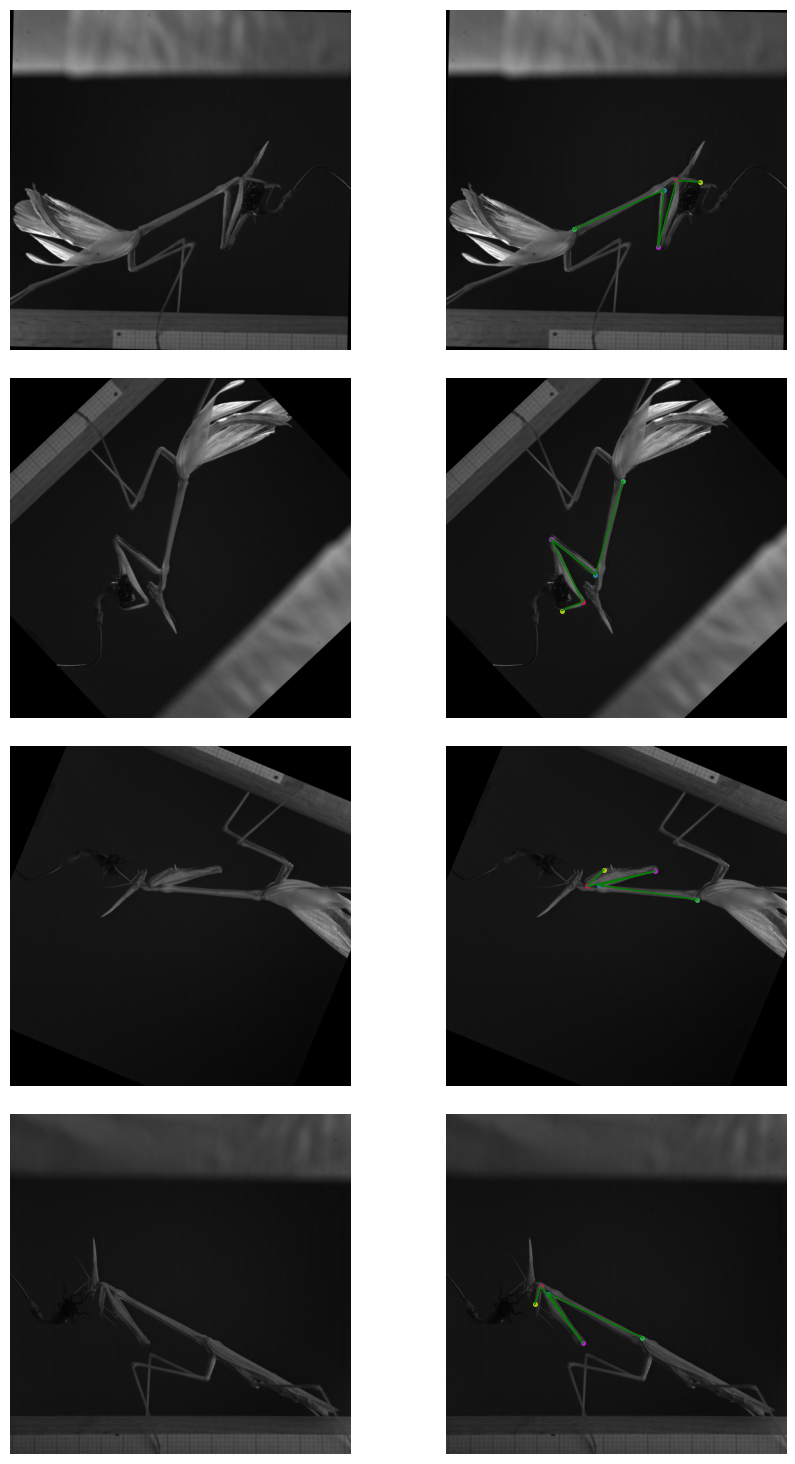

In [24]:
train_dataset = KeyPointsDataset(
    train_keys, train_aug, workers=2, use_multiprocessing=True
)
validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False, workers=2, use_multiprocessing=True
)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
#assert sample_keypoints.max() == 1.0
#assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 5, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

##  Baseline model building

Builds a simple CNN model for keypoint detection without a pre-trained backbone.


In [ ]:
def get_baseline_model():

    model = keras.Sequential(
        [
            keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            layers.Conv2D(32, kernel_size=3, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(64, kernel_size=3, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(128, kernel_size=3, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(NUM_KEYPOINTS),
        ]
    )
    return model

In [ ]:
get_baseline_model().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 640, 640, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 320, 320, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 320, 320, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 160, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 160, 160, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 80, 80, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 819200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │     104,857,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,952,266 (400.36 MB)

 Trainable params: 104,952,266 (400.36 MB)

 Non-trainable params: 0 (0.00 B)

## Model building

Builds a keypoint detection model using MobileNetV2 as the backbone.

This function constructs a Keras model that utilizes the MobileNetV2 architecture (pre-trained on ImageNet)
for feature extraction, followed by separable convolution layers for detecting keypoints. The model is
designed for predicting the (x, y) coordinates of keypoints in images. The weights of the MobileNetV2
backbone are partly frozen, and only the last three layers of MobileNetV2 and the added layers will be trained.

The model architecture consists of:
1. A MobileNetV2 backbone (pre-trained on ImageNet) for feature extraction.
2. A Dropout layer to prevent overfitting.
3. Two separable convolution layers to predict the keypoints with ReLU and sigmoid activations, respectively.

The output of the model is a tensor of predicted keypoints, with each keypoint being represented by
two values (x, y), and the number of keypoints is defined by `NUM_KEYPOINTS`.

In [29]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    for layer in backbone.layers[-3:]:
        layer.trainable=True

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)

    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=4, strides=1, activation="relu"
    )(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu"
    )(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


## (Baseline) Model compilation and training

Defining a callback function to check overfitting and fitting the model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=20,
)

Train the baseline model

In [ ]:
baseline = get_baseline_model()
baseline.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
history = baseline.fit(train_dataset, validation_data=validation_dataset, epochs=150, callbacks=[callback])

Train the model

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
historyMobileNetV2 = model.fit(train_dataset, validation_data=validation_dataset, epochs=150, callbacks=[callback])

Save the baseline model

In [ ]:
baseline.save('/content/drive/MyDrive/MantisModels/baseline.keras')

Save the model

In [ ]:
model.save('/content/drive/MyDrive/MantisModels/mantisAI.keras')

## Training Performance

Comparing the training performance

In [1]:
#plot model training and validation
loss = historyMobileNetV2.history['loss']
val_loss = historyMobileNetV2.history['val_loss']
baseline_loss = history.history['loss']
baseline_val_loss = history.history['val_loss']
if len(loss) > len(baseline_loss):
  epochs = range(len(loss))
else:
  epochs = range(len(baseline_loss))

plt.plot(epochs, loss, 'b', label='training_loss')
plt.plot(epochs, val_loss, 'c', label='validation_loss')
plt.plot(epochs, baseline_loss, 'r', label='baseline_training_loss')
plt.plot(epochs, baseline_val_loss, 'm', label='baseline_validation_loss')
plt.title('Training & Validation performance')
plt.legend(loc=0)
plt.savefig('/content/drive/MyDrive/MantisModels/training_validation_loss220.png')
plt.show()



NameError: name 'historyMobileNetV2' is not defined

# Predictions on Test Set

get images and annotations of the test set

In [43]:
IMG_DIR_TEST = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisAIData\test"
JSON_TEST = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisAIData\MantisTest.json"
KEYPOINT_DEF = r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisKeypointDef.csv"

# Load the ground-truth annotations.
with open(JSON_TEST) as infile:
    json_data = json.load(infile)

# Prepare the mapping for images and annotations
images = {image['id']: image for image in json_data['images']}
annotations = {annotation['image_id']: annotation for annotation in json_data['annotations']}

# Process keypoints to ensure they are 2D
raw_keypoints = annotations.get('keypoints', [])
if raw_keypoints:
  # Reshape the keypoints into a 2D array with shape (num_keypoints, 3)
  reshaped_keypoints = [raw_keypoints[i:i + 3] for i in range(0, len(raw_keypoints), 3)]
else:
  reshaped_keypoints = []

# Generate the desired output structure
json_dict_test = {}
for image_id, image_data in images.items():
    annotation = annotations.get(image_id, {})

    #convert joints to 2D Array
    keypoints = annotation.get('keypoints', [])
    joints_2d = np.array(keypoints).reshape(-1, 3) if keypoints else []

    # Map the image and annotation data to the desired structure
    json_dict_test[image_data['file_name']] = {
        'img_bbox': annotation.get('bbox', []),
        'img_height': image_data['height'],
        'img_path': image_data['file_name'],
        'img_width': image_data['width'],
        'joints': joints_2d.tolist()
    }

define a function to get the test data


In [44]:
def get_mantis_test(name):
    """
    Loads the imae and its annotations for a given file name from the JSON data.

    Args:
             name(str) -- The name of the image to load, as listed in json_dict

    Returns:
                dict -- A dictionary with the following information:
                    - img_bbox: The bounding box coordinates for the image
                    - img_height: The height of the image in pixels
                    - img_path: The path to the image file
                    - img_width: The width of the image in pixels
                    - joints: The joint coordinates/Keypoints for the image ([x,y,visibility])
                    - img_data: The image data as a NumPy array
    """
    data = json_dict_test[name]
    img_data = plt.imread(os.path.join(IMG_DIR_TEST, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

Prepare test data generator 

In [46]:
class KeyPointsTestDataset(keras.utils.PyDataset):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=False, **kwargs):
        """
        Initializes the KeyPointsDataset for managing and preprocessing test data.

        Args:
            image_keys (list): A list of image identifiers used to access the dataset
            aug (callable): A function or object to apply data augmentation to images and keypoints
            batch_size (int, optional): the number of samples per batch. Defaults to BATCH_SIZE
            train (bool, optional): Indicates whether the dataset is used for Training (True) or Validation/Testing (False). Defaults to False

        Returns:
            Stores images keys, augmentation method, batch size, and mode (train/test)
            Calls the on_epoch_end method to prepare the dataset for the first epoch
        """
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        """ Calculates the number of batches in the dataset."""
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        """ Prepares the dataset at the end of each epoch. (Generates a array of indices for the dataset and shuffles them if in training mode)"""
        self.indexes = np.arange(len(self.image_keys))
        # No shuffling for test data
        #if self.train:
        #    np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Generates one batch of data.

        Args: index(int): Batch index to retrieve
        Returns: tuple (simplified definition: Ordered/sorted form of list): A tuple containing the batch of images and their corresponding keypoints
        """
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        """
        Loads and preprocesses a batch of images and their keypoints.

        Args:
            image_keys_temp (list): A temporary list of image keys to load and preprocess

        Returns:
            tuple:
                - batch_images (np.ndarray): A batch of images
                - batch_keypoints (np.ndarray): A batch of normalized keypoints
        """
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_mantis_test(key) # Assuming get_mantis function is defined elsewhere and handles test data
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 5 * 2)

        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

create the test dataset

In [ ]:
test_dataset = KeyPointsTestDataset(
    list(json_dict_test.keys()), test_aug, workers=2, use_multiprocessing=True
)

model_test = keras.models.load_model(r"C:\Users\linus\MantisAI\MantisAI\3_Model\MantisAI_TrainedModels\mantisAIUnfreezeMobileNet.keras")
predictions = model_test.predict(test_dataset).reshape(-1, 5, 2) * IMG_SIZE

In [ ]:
# prompt: create a code that save the predicitions with the according image name as well as the ground truth values to a json file

import json

# Assuming 'predictions' is your array of predictions and 'test_dataset' is your test dataset
# and 'test_keys' contains the file names in test dataset

# Create a list to store the results
results = []

# Iterate through the predictions and filenames
for i, pred in enumerate(predictions):
    # Reshape the prediction as done previously (assuming a 5 keypoints setup)
    reshaped_pred = pred.reshape(-1, 5, 2) * IMG_SIZE

    # Get the corresponding image filename
    image_filename = list(json_dict_test.keys())[i]

    # Get the ground truth keypoints
    data = get_mantis_test(image_filename)
    ground_truth_keypoints = np.array(data["joints"])[:, :2] # Extract only x,y coordinates

    # Append to the result list
    results.append({
        "image_name": image_filename,
        "predictions": reshaped_pred.tolist(),  # Convert numpy to list
        "ground_truth": ground_truth_keypoints.tolist()  # Convert numpy to list
    })


# Save the results to a JSON file
with open('/content/drive/MyDrive/MantisModels/predictions.json', 'w') as f:
    json.dump(results, f, indent=4)